# Full processing example

In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.rc('figure', figsize=(13, 7))
from IPython.display import display, Markdown, Latex  # Display cells with dynamic content
from string import Template  # Replace text with $ instead of {}, much better for LaTeX equations

def round_numbers(data: dict, places: int) -> dict:
  """Setup floating point variables for string substitution

  Parameters
  ----------
  data : dict
      A dictionary of values with string keys
  places : int
      Number of decimal places in string representation

  Returns
  -------
  dict
      A copy of `data` with floats converted to strings
  """
  format_string = '{:.' + str(places) + 'f}'
  result = dict()
  for k, v in data.items():
    if isinstance(v, float):
      result[k] = format_string.format(v)
    else:
      result[k] = v
  return result

tex = lambda text, data, places = 3: display(Latex(Template(text).substitute(round_numbers(data, places))))
md = lambda text, data, places = 3: display(Markdown(Template(text).substitute(round_numbers(data, places))))

## Data definition

In [2]:
numlevels = 32

# KoSMOS data
datastring = 'ZIQLRLVQVJPKRLRMUPUNTOTOTMSNSNSNULQLUMTHRMTOUPVOULSNSNTOTNUNT' \
  'OTNSNSNSNUOULUOUIXSXNTOUOUPUPUNSKSNTLQLSNTOUHSNSNSNSNSNSNSIQPUHUPUOTOTOU' \
  'MTMSNTOTOTOTOTNSNSNSNSLSNSHTOTOTNSLSMSLSNSMSNTNSNTLSNSNTMUPUOTOTOUOTOTOT' \
  'OTNUPVPUNTOTJRMSNTNSNSNSNSNSMRLQJUPVNSNTOTMSLTNTOWNSNSNSNTNTOTMRLVKRLSLS' \
  'NSNTOTOTOUOTOTNTNSMTNUNTOTOTOUIWRWMTOTKSNSNUNSNUPUPUOTNTHTOTOUOUNSNUMUKS' \
  'HYTXSXOTOTOTOUOTOTOTLSNSNULSNSNTOTOULSNTNSNUPVOTOTOVFSNSNUHXSXSXQVMVNSLR' \
  'LQKVPUPUNUNUNUPUOTNTOTOTMSMTLSNSNSNSNTOTOVOTNUNSNSLQLSNSNSNTNSKWRWRWRWRW' \
  'JSMRMSNTOUNUOUJSNTOTOTNSMRLQGRMRLSNTOTOTOTMRKULSNSNTMSNTNVOTOTMTOTOTMRMU' \
  'OTOVLRMTOUPUPULTOTOTMRFTOTMYKPIUNSMRMRMSNTMTHRMSNUGVQWPUOUPVOTNSNSNSNSNT' \
  'OVHQLSLSMRMSNZORMUPUOTOVNSMSNSNSMTOTOTOTNTOTLSNSNSNSNSNSNVOTOUKSLQKPKSKR' \
  'MRJUNTNSNTOUPUJPKVMSNTNSNUPUPUPVPUKVLSNVJPKSNTKSNSNSIONSNSNUNTORKVPUOTOV' \
  'MSNSMTOTOTNTOVQVPUJOJSNTNTOTNSNSNULWRWQWRXSXSXSXSXSXRWRWRXOTOTOTOVNSNSNT' \
  'NTOTNSNSNSNUOTOTOTNSNSKVOTOTHUPXSXSXQVLSNTNTMTOTMTOUPUPVP'
data = [ord(c) - ord('A') + 4 for c in datastring]

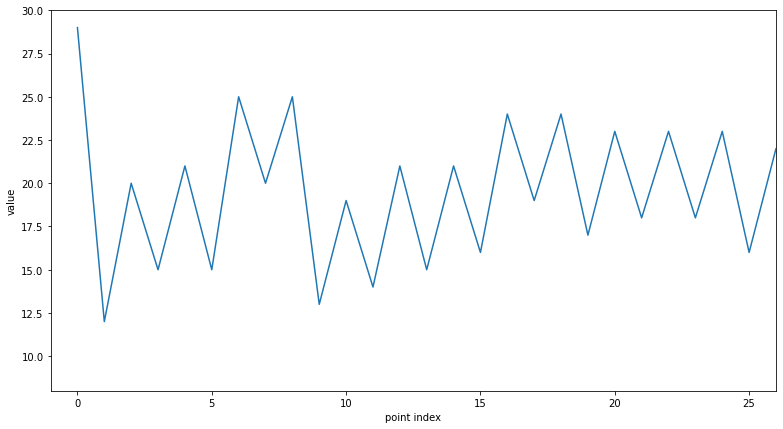

In [3]:
plt.plot(data)
plt.xlim([-1, 26])
plt.ylabel('value')
plt.xlabel('point index')
plt.show()

## Transfer array

In [4]:
transfers = []
for i, d in enumerate(data[:-1]):
  transfers.append((d, data[i+1]))

transfer_counts = {}
for t in transfers:
  if t in transfer_counts:
    transfer_counts[t] += 1
  else:
    transfer_counts[t] = 1

In [5]:
table_rows = [ '| From\\To | &nbsp;&nbsp;' + ' | &nbsp;&nbsp;'.join([str(n + 1) for n in range(numlevels)]),
'| --: '*(numlevels + 1) + '|' ]
for m in reversed(range(numlevels)):
  row = '| **' + str(m+1) + '** |'
  for n in range(numlevels):
    if m == n:
      row += ' X |'
    elif (m+1, n+1) in transfer_counts:
      row += ' ' + str(transfer_counts[(m+1, n+1)]) + '|'
    else:
      row += '.|'
  table_rows.append(row)

table = '\n'.join(table_rows)
display(Markdown(table))

| From\To | &nbsp;&nbsp;1 | &nbsp;&nbsp;2 | &nbsp;&nbsp;3 | &nbsp;&nbsp;4 | &nbsp;&nbsp;5 | &nbsp;&nbsp;6 | &nbsp;&nbsp;7 | &nbsp;&nbsp;8 | &nbsp;&nbsp;9 | &nbsp;&nbsp;10 | &nbsp;&nbsp;11 | &nbsp;&nbsp;12 | &nbsp;&nbsp;13 | &nbsp;&nbsp;14 | &nbsp;&nbsp;15 | &nbsp;&nbsp;16 | &nbsp;&nbsp;17 | &nbsp;&nbsp;18 | &nbsp;&nbsp;19 | &nbsp;&nbsp;20 | &nbsp;&nbsp;21 | &nbsp;&nbsp;22 | &nbsp;&nbsp;23 | &nbsp;&nbsp;24 | &nbsp;&nbsp;25 | &nbsp;&nbsp;26 | &nbsp;&nbsp;27 | &nbsp;&nbsp;28 | &nbsp;&nbsp;29 | &nbsp;&nbsp;30 | &nbsp;&nbsp;31 | &nbsp;&nbsp;32
| --: | --: | --: | --: | --: | --: | --: | --: | --: | --: | --: | --: | --: | --: | --: | --: | --: | --: | --: | --: | --: | --: | --: | --: | --: | --: | --: | --: | --: | --: | --: | --: | --: |
| **32** |.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.| X |
| **31** |.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.| X |.|
| **30** |.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.| X |.|.|
| **29** |.|.|.|.|.|.|.|.|.|.|.| 1|.|.|.|.|.| 1|.|.|.|.|.|.|.|.|.|.| X |.|.|.|
| **28** |.|.|.|.|.|.|.|.|.|.|.|.|.| 1|.|.|.|.|.|.|.|.| 1|.|.|.|.| X |.|.|.|.|
| **27** |.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.| 1| 2|.| 2| 1| 11|.|.|.|.| X |.|.|.|.|.|
| **26** |.|.|.|.|.|.|.|.|.|.|.|.| 1|.|.| 1| 1|.| 1| 1| 9|.|.|.|.| X |.|.|.|.|.|.|
| **25** |.|.|.|.|.|.|.|.| 1|.| 1|.| 2| 1| 3| 3| 4| 7| 6| 3|.|.|.|.| X |.|.|.|.|.|.|.|
| **24** |.|.|.|.|.|.|.|.|.| 1| 3| 2| 3| 3| 8| 3| 15| 17| 24|.|.|.|.| X |.|.|.|.|.|.|.|.|
| **23** |.|.|.|.|.|.|.|.|.|.| 4|.| 1| 2| 5| 15| 30| 84|.|.|.|.| X |.|.|.| 1|.|.|.|.|.|
| **22** |.|.|.|.|.|.|.|.|.|.| 2| 2|.| 4| 9| 12| 98|.|.|.|.| X |.|.|.|.| 11|.|.|.|.|.|
| **21** |.|.|.|.|.|.|.|.| 1|.|.|.| 1| 2| 8| 13|.|.|.|.| X |.|.|.|.| 8| 2|.|.|.|.|.|
| **20** |.|.|.|.|.|.|.|.|.| 1|.|.| 1| 2| 5|.|.|.| 1| X |.|.|.|.| 4| 2|.|.|.|.|.|.|
| **19** |.|.|.|.|.|.|.|.|.|.|.| 1|.| 4|.|.|.|.| X |.|.|.|.| 23| 7|.| 1|.|.|.|.|.|
| **18** |.|.|.|.|.|.|.|.|.|.|.|.| 1|.|.|.| 1| X |.|.| 2|.| 78| 22| 8| 1|.|.|.|.|.|.|
| **17** |.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.| X |.|.|.|.| 80| 45| 21| 3|.|.|.| 1|.|.|.|
| **16** |.|.|.|.|.|.|.|.|.|.|.|.|.|.|.| X |.|.|.|.| 12| 15| 13| 5| 1|.|.| 1|.|.|.|.|
| **15** |.|.|.|.|.|.|.|.|.|.|.|.|.|.| X |.|.|.|.| 7| 4| 20| 2| 2| 2| 1|.|.|.|.|.|.|
| **14** |.|.|.|.|.|.|.|.|.|.|.|.|.| X |.|.|.|.| 2|.| 3| 7|.| 1| 5| 1|.|.|.|.|.|.|
| **13** |.|.|.|.|.|.|.|.|.|.|.|.| X |.|.|.|.| 1| 3|.| 1| 3|.| 2|.|.|.|.|.|.|.|.|
| **12** |.|.|.|.|.|.|.|.|.|.|.| X |.|.|.|.|.| 1|.| 2|.|.|.| 1|.| 1| 1|.|.|.|.|.|
| **11** |.|.|.|.|.|.|.|.|.|.| X |.|.|.|.|.|.|.|.| 1| 2| 1| 2| 2|.|.| 1| 1|.|.|.|.|
| **10** |.|.|.|.|.|.|.|.|.| X |.|.|.|.|.|.|.|.|.|.| 1|.|.|.| 1|.|.|.|.|.|.|.|
| **9** |.|.|.|.|.|.|.|.| X |.|.|.|.|.|.|.|.|.|.|.|.| 1| 1|.|.|.|.|.|.|.|.|.|
| **8** |.|.|.|.|.|.|.| X |.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|
| **7** |.|.|.|.|.|.| X |.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|
| **6** |.|.|.|.|.| X |.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|
| **5** |.|.|.|.| X |.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|
| **4** |.|.|.| X |.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|
| **3** |.|.| X |.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|
| **2** |.| X |.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|
| **1** | X |.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|

## Rain flow counting

In [6]:
from math import copysign
sign = lambda x: copysign(1, x)

def make_droplets(data: list, direction: int) -> list:
  assert direction != 0
  direction = sign(direction)
  droplets = []
  taken_peaks = []
  for i, start in enumerate(data[:-1]):
    if sign(data[i + 1] - start) == direction:
      drop = { 'from': start, 'points': [(i, start)]}
      current_d = start
      for j in range(i+1, len(data)):
        if (data[j] - current_d) * direction >= 0:  # Fall on the next line
          taken_index = next((i for i, x in enumerate(taken_peaks) if x['index'] == j), -1)
          old_intercept = taken_peaks[taken_index]['intercept'] if taken_index != -1 else np.NaN

          if len(drop['points']) > 1:
            # Move the last point to intercept this roof nicely
            intercept_delta_x = (current_d - data[j-1]) / (data[j] - data[j-1])
            drop['points'][-1] = (drop['points'][-1][0] + intercept_delta_x, drop['points'][-1][1])
            # Store all interceptions to allow checking for collisons
            if taken_index == -1:
               taken_peaks.append({'index': j, 'intercept': current_d})
            else:
              taken_peaks[taken_index] = { 'index': j, 'intercept': current_d}

          if taken_index != -1:
            lerp_arg = ((old_intercept - direction * 0.2) - data[j-1]) / (data[j] - data[j-1])
            
            drop['points'].append((j-1+ lerp_arg, data[j-1] + lerp_arg * (data[j] - data[j-1])))
            drop['to'] = old_intercept
            break

          drop['points'].append((j, data[j]))
          current_d = data[j]

        else:
          drop['points'].append((j, current_d))  # Fall down straight

          if (data[j] - drop['from']) * direction < 0:  # Termination condition
            drop['to'] = current_d
            break

        if j == len(data) - 1:  # Extend beyond last point
          drop['points'].append((j + 1, current_d))
          drop['to'] = current_d

      droplets.append(drop)
  return droplets

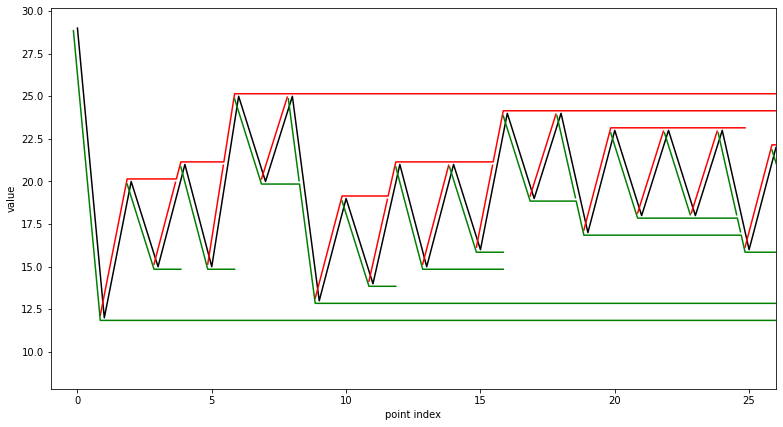

In [7]:
plt.plot(data, c='black')

drops_top = make_droplets(data, 1)
for drop in drops_top:
  points = np.array(drop['points'])
  # Offset diagonally by a small value to display next to original data
  points = points + np.tile(np.array([-0.15, 0.15]), (points.shape[0], 1))
  plt.plot(points[:,0], points[:,1], c='red')

drops_bottom = make_droplets(data, -1)
for drop in drops_bottom:
  points = np.array(drop['points'])
  points = points + np.tile(np.array([-0.15, -0.15]), (points.shape[0], 1))
  plt.plot(points[:,0], points[:,1], c='green')

plt.xlim([-1, 26])
plt.ylabel('value')
plt.xlabel('point index')
plt.show()

In [8]:
drops_all = drops_top + drops_bottom
halfcycle_counts = {}
for d in drops_all:
  t = (d['from'], d['to'])
  if t in halfcycle_counts:
    halfcycle_counts[t] += 1
  else:
    halfcycle_counts[t] = 1

In [9]:
table_rows = [ '| From\\To | &nbsp;&nbsp;' + ' | &nbsp;&nbsp;'.join([str(n + 1) for n in range(numlevels)]),
'| --: '*(numlevels + 1) + '|' ]
for m in reversed(range(numlevels)):
  row = '| **' + str(m+1) + '** |'
  for n in range(numlevels):
    if m == n:
      row += ' X |'
    elif (m+1, n+1) in halfcycle_counts:
      if (n+1, m+1) in halfcycle_counts:
        row += ' [' + str(halfcycle_counts[(m+1, n+1)]) + ']|'
      else:
        row += ' ' + str(halfcycle_counts[(m+1, n+1)]) + '|'
    else:
      row += '.|'
  table_rows.append(row)

table = '\n'.join(table_rows)
display(Markdown(table))

| From\To | &nbsp;&nbsp;1 | &nbsp;&nbsp;2 | &nbsp;&nbsp;3 | &nbsp;&nbsp;4 | &nbsp;&nbsp;5 | &nbsp;&nbsp;6 | &nbsp;&nbsp;7 | &nbsp;&nbsp;8 | &nbsp;&nbsp;9 | &nbsp;&nbsp;10 | &nbsp;&nbsp;11 | &nbsp;&nbsp;12 | &nbsp;&nbsp;13 | &nbsp;&nbsp;14 | &nbsp;&nbsp;15 | &nbsp;&nbsp;16 | &nbsp;&nbsp;17 | &nbsp;&nbsp;18 | &nbsp;&nbsp;19 | &nbsp;&nbsp;20 | &nbsp;&nbsp;21 | &nbsp;&nbsp;22 | &nbsp;&nbsp;23 | &nbsp;&nbsp;24 | &nbsp;&nbsp;25 | &nbsp;&nbsp;26 | &nbsp;&nbsp;27 | &nbsp;&nbsp;28 | &nbsp;&nbsp;29 | &nbsp;&nbsp;30 | &nbsp;&nbsp;31 | &nbsp;&nbsp;32
| --: | --: | --: | --: | --: | --: | --: | --: | --: | --: | --: | --: | --: | --: | --: | --: | --: | --: | --: | --: | --: | --: | --: | --: | --: | --: | --: | --: | --: | --: | --: | --: | --: |
| **32** |.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.| X |
| **31** |.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.| X |.|
| **30** |.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.| X |.|.|
| **29** |.|.|.|.|.|.|.|.| [1]|.| 1|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.| X |.|.|.|
| **28** |.|.|.|.|.|.|.|.|.| [1]| [1]|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.| X |.|.|.|.|
| **27** |.|.|.|.|.|.|.|.| [1]|.| [1]| [1]|.|.| 1|.|.|.|.|.| [1]| [11]| [1]|.|.|.| X |.|.|.|.|.|
| **26** |.|.|.|.|.|.|.|.|.|.| [2]| [1]|.| [1]|.|.|.|.|.| [1]| [9]|.|.|.|.| X |.|.|.|.|.|.|
| **25** |.|.|.|.|.|.|.|.|.| [1]|.| [2]| [3]| [3]| [6]| [5]| [1]| [4]| 1| [5]|.|.|.|.| X |.|.|.|.|.|.|.|
| **24** |.|.|.|.|.|.|.|.|.|.| [5]| [1]| [3]| [4]| [8]| [3]| [13]| [12]| [30]|.|.|.|.| X |.|.|.|.|.|.|.|.|
| **23** |.|.|.|.|.|.|.|.|.|.|.|.| [3]| [1]| [5]| [14]| [25]| [93]|.|.|.|.| X |.|.|.| [1]|.|.|.|.|.|
| **22** |.|.|.|.|.|.|.|.|.|.|.| [1]|.| [4]| [4]| [8]| [110]|.|.|.|.| X |.|.|.|.| [11]|.|.|.|.|.|
| **21** |.|.|.|.|.|.|.|.|.|.|.|.|.| [1]| [5]| [17]|.| [2]|.|.| X |.|.|.|.| [9]| [1]|.|.|.|.|.|
| **20** |.|.|.|.|.|.|.|.|.|.|.|.|.|.| [9]|.|.|.| [1]| X |.|.|.|.| [5]| [1]|.|.|.|.|.|.|
| **19** |.|.|.|.|.|.|.|.|.|.|.|.|.| [5]|.|.|.|.| X | [1]|.|.|.| [30]|.|.|.|.|.|.|.|.|
| **18** |.|.|.|.|.|.|.|.|.|.|.|.| [1]|.|.|.| [1]| X |.|.| [2]|.| [93]| [12]| [4]|.|.|.|.|.|.|.|
| **17** |.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.| X | [1]|.|.|.| [110]| [25]| [13]| [1]|.|.|.|.|.|.|.|
| **16** |.|.|.|.|.|.|.|.|.|.|.|.|.|.|.| X |.|.|.|.| [17]| [8]| [14]| [3]| [5]|.|.|.|.|.|.|.|
| **15** |.|.|.|.|.|.|.|.|.|.|.|.|.|.| X |.|.|.|.| [9]| [5]| [4]| [5]| [8]| [7]|.|.|.|.|.|.|.|
| **14** |.|.|.|.|.|.|.|.|.|.|.|.|.| X |.|.|.|.| [5]|.| [1]| [4]| [1]| [4]| [3]| [1]|.|.|.|.|.|.|
| **13** |.|.|.|.|.|.|.|.|.|.|.|.| X |.|.|.|.| [1]|.|.|.|.| [3]| [3]| [3]|.|.|.|.|.|.|.|
| **12** |.|.|.|.|.|.|.|.|.|.|.| X |.|.|.|.|.|.|.|.|.| [1]|.| [1]| [2]| [1]| [1]|.|.|.|.|.|
| **11** |.|.|.|.|.|.|.|.|.|.| X |.|.|.|.|.|.|.|.|.|.|.|.| [5]|.| [2]| [2]| [1]|.|.|.|.|
| **10** |.|.|.|.|.|.|.|.|.| X |.|.|.|.|.|.|.|.|.|.|.|.|.|.| [1]|.|.| [1]|.|.|.|.|
| **9** |.|.|.|.|.|.|.|.| X |.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.| [1]|.| [1]|.|.|.|
| **8** |.|.|.|.|.|.|.| X |.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|
| **7** |.|.|.|.|.|.| X |.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|
| **6** |.|.|.|.|.| X |.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|
| **5** |.|.|.|.| X |.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|
| **4** |.|.|.| X |.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|
| **3** |.|.| X |.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|
| **2** |.| X |.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|
| **1** | X |.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|

## Transfer and halfcycle check

$$ N - 1 = \sum{\Delta LL_{TA}} = \sum{\Delta LL_{top}} + \sum{\Delta LL_{bottom}} $$

In [10]:
num = {
  'n': len(data),
  'llta': len(transfers),
  'lltop': len(drops_top),
  'llbottom': len(drops_bottom)
}
tex(r'$$$$ $n - 1 = $llta = $lltop + $llbottom $$$$', num)

<IPython.core.display.Latex object>